In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
import xarray as xr
import numpy as np
import pop_tools 
# import ncar_jobqueue
# from dask.distributed import Client
import utils

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
import cmocean
import matplotlib.path as mpath

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='04:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
#cluster.close()

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(24) 
client

Client Scheduler: tcp://128.117.208.177:40021 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT
area_x1=ds_grid_x1.TAREA
area_m_x1=ds_grid_x1.TAREA * 1e-4
lons_norm_x1 = utils.normal_lons(lons_x1)

In [6]:
## based on CESM1-LE -- will redo!!
ds_siz_mask = xr.open_dataset('/glade/u/home/kristenk/antarc_marine_pred_work/TOE/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))

In [7]:
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY'

files = sorted(glob(f'{path}/CESM2-LE-FEISTY-HIST-SSP370-cmip6-ensmem-????????_1850-2100.nc'))
        
ds_feisty_x1=xr.open_mfdataset(files,concat_dim="member_id", coords='minimal', compat="override", combine='nested')

In [8]:
files[24]

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY/CESM2-LE-FEISTY-HIST-SSP370-cmip6-ensmem-1251.005_1850-2100.nc'

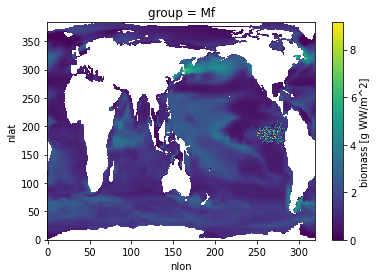

In [9]:
ds_feisty_x1.isel(member_id=24,time=0).biomass.sel(group='Mf').plot()

### Simplify FEISTY fish groups

In [10]:
ds_feisty_x1['total_forage'] = ds_feisty_x1.biomass.sel(group='Sf') + ds_feisty_x1.biomass.sel(group='Mf')
ds_feisty_x1['total_pelagic'] = ds_feisty_x1.biomass.sel(group='Sp') + ds_feisty_x1.biomass.sel(group='Mp') + ds_feisty_x1.biomass.sel(group='Lp')
ds_feisty_x1['total_demersal'] = ds_feisty_x1.biomass.sel(group='Sd') + ds_feisty_x1.biomass.sel(group='Md') + ds_feisty_x1.biomass.sel(group='Ld')
ds_feisty_x1['total_fish'] = ds_feisty_x1['total_forage'] + ds_feisty_x1['total_pelagic']  + ds_feisty_x1['total_demersal']

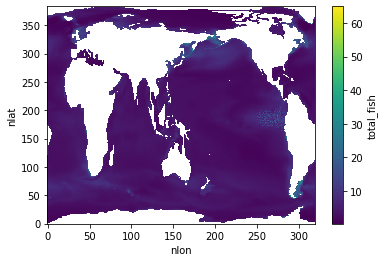

In [11]:
ds_feisty_x1['total_fish'].isel(member_id=24,time=0).plot()

In [12]:
ds_feisty_x1 = ds_feisty_x1.drop(['biomass','fish_yield','production'])

In [13]:
ds_feisty_x1['time'] = np.arange(1850,2101,1)

### Now make an ice obligate fish dataset

In [14]:
### read in seasonal averages of ice
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-annual-mean-IFRAC.nc'
ds = xr.open_dataset(file)
ds = ds.isel(nlat=slice(0,55))

In [15]:
ds = ds.load()

In [16]:
ds=ds.isel(time=slice(0,250))

In [17]:
ds_feisty_x1 = ds_feisty_x1.isel(time=slice(0,250))
ds_feisty_x1 = ds_feisty_x1.isel(nlat=slice(0,55))
ds_feisty_x1

,Array,Chunk
Bytes,1.64 GiB,33.57 MiB
Shape,"(50, 250, 55, 320)","(1, 250, 55, 320)"
Count,450 Tasks,50 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.64 GiB,33.57 MiB
Shape,"(50, 250, 55, 320)","(1, 250, 55, 320)"
Count,550 Tasks,50 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [18]:
ds_feisty_x1['total_forage_ice'] = ds_feisty_x1['total_forage'] * ds.IFRAC
ds_feisty_x1['total_pelagic_ice'] = ds_feisty_x1['total_pelagic'] * ds.IFRAC
ds_feisty_x1['total_demersal_ice'] = ds_feisty_x1['total_demersal'] * ds.IFRAC
ds_feisty_x1['total_fish_ice'] = ds_feisty_x1['total_fish'] * ds.IFRAC

In [19]:
ds_feisty_x1 = ds_feisty_x1.load()

### Write out the total fish dataset so that I can use it elsewhere

In [20]:
# ds_out = xr.Dataset()
# ds_out['total_fish'] = ds_feisty_x1['total_fish']
# ds_out['total_fish_ice'] = ds_feisty_x1['total_fish_ice']

In [22]:
fileout = '/glade/derecho/scratch/kristenk/ToE_saved_data/FEISTY_ann_tot_fish.nc'
ds_feisty_x1.to_netcdf(fileout, mode='w')

#ds_out = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/FEISTY_ann_tot_fish.nc')

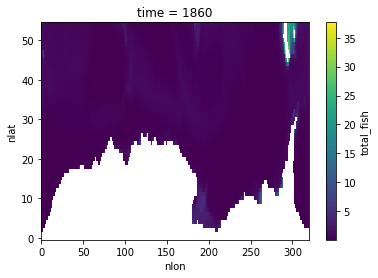

In [26]:
ds_feisty_x1['total_fish'].isel(member_id=24,time=10).plot()

# Some prelim analysis

### Make a map of fish changes, 1950 to 2100

In [10]:
ds_start = ds_out.isel(time=slice(70,100)).mean(dim=('time','member_id')).load()

In [11]:
ds_end = ds_out.isel(time=slice(220,249)).mean(dim=('time','member_id')).load()

### Changes in total fish

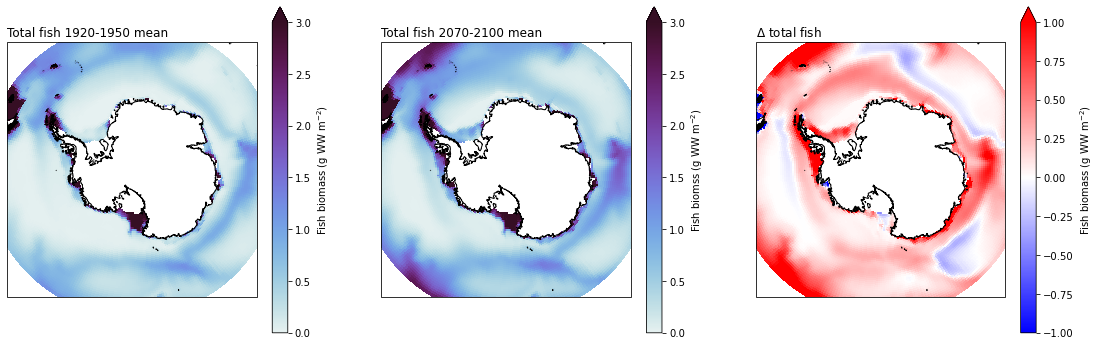

In [12]:
cmap = cmocean.cm.dense
cmap_diff = 'bwr'
extent = [-180, 180, -90, -55]

fig = plt.figure(figsize=(19,6))

############################################################################## start period (1920-1950)


ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('Total fish 1920-1950 mean', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_start.total_fish)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=3, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomass (g WW m$^{-2}$)');

###############################################

ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('Total fish 2070-2100 mean', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=3, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomss (g WW m$^{-2}$)');
############################################################################## diff = end period (2070-2100) - start period (1920-1950)





ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('${\Delta}$ total fish', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish-ds_start.total_fish)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=-1, vmax=1, 
                 cmap=cmap_diff,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomass (g WW m$^{-2}$)');

###############################################


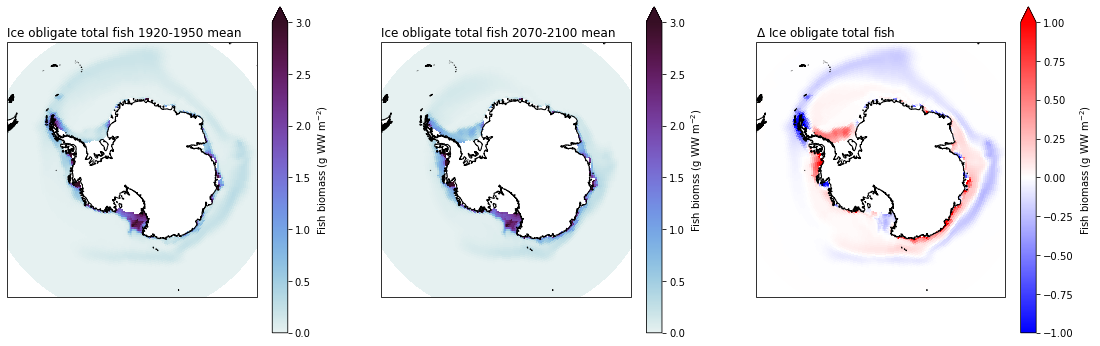

In [13]:
cmap = cmocean.cm.dense
cmap_diff = 'bwr'
extent = [-180, 180, -90, -55]

fig = plt.figure(figsize=(19,6))

############################################################################## start period (1920-1950)


ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('Ice obligate total fish 1920-1950 mean', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_start.total_fish_ice)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=3, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomass (g WW m$^{-2}$)');

###############################################

ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('Ice obligate total fish 2070-2100 mean', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish_ice)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=3, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomss (g WW m$^{-2}$)');
############################################################################## diff = end period (2070-2100) - start period (1920-1950)





ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('${\Delta}$ Ice obligate total fish', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish_ice-ds_start.total_fish_ice)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=-1, vmax=1, 
                 cmap=cmap_diff,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomass (g WW m$^{-2}$)');

###############################################
